In [35]:
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
PROJECT_ROOT = os.path.abspath("..")
sys.path.insert(0, PROJECT_ROOT)
from script.csvs_to_sql import detect_delimiter
CSV_PATH = "../data_acidentes_prf/"
year = "2025"


In [ ]:
def files_per_year(year:str|int) -> list[str]:
    year = str(year)
    files_per_year = []
    files = os.listdir(CSV_PATH)
    for file in files:
        if year in file:
            files_per_year.append(file)
    return files_per_year

def concat_df(files:list[str]) -> pd.DataFrame:
    dfs = [
        pd.read_csv(
            f"{CSV_PATH}{file}",
            encoding="latin1",
            sep=detect_delimiter(f"{CSV_PATH}{file}")
        )
        for file in files
    ]

    df = pd.concat(dfs, ignore_index=True)
    df = df.drop_duplicates()
    return df

files = files_per_year(year)
df = concat_df(files)
df.shape


(769905, 41)

In [37]:
df.columns


Index(['id', 'pesid', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br',
       'km', 'municipio', 'causa_principal', 'causa_acidente',
       'ordem_tipo_acidente', 'tipo_acidente', 'classificacao_acidente',
       'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista',
       'tracado_via', 'uso_solo', 'id_veiculo', 'tipo_veiculo', 'marca',
       'ano_fabricacao_veiculo', 'tipo_envolvido', 'estado_fisico', 'idade',
       'sexo', 'ilesos', 'feridos_leves', 'feridos_graves', 'mortos',
       'latitude', 'longitude', 'regional', 'delegacia', 'uop', 'pessoas',
       'ignorados', 'feridos', 'veiculos'],
      dtype='object')

### Exibindo os 10 municípios que tiveram mais mortes no ano correspondente

In [38]:
try:
  Top_10_most_dangerous_municipios = (
      df.groupby(["municipio", "uf"], as_index=False)["mortos"]
        .sum()
        .nlargest(10, "mortos")
        .reset_index(drop=True)
  )
except  KeyError as e:
  print("The selected columns do not exits")

Top_10_most_dangerous_municipios


,municipio,uf,mortos
0,GRAO MOGOL,MG,325.0
1,BRASILIA,DF,312.0
2,CURITIBA,PR,270.0
3,CORRENTINA,BA,215.0
4,GUARAPUAVA,PR,213.0
5,SAO JOSE DOS PINHAIS,PR,205.0
6,BARREIRAS,BA,183.0
7,RIACHAO DAS NEVES,BA,176.0
8,PRUDENTOPOLIS,PR,162.0
9,TERESINA,PI,161.0


### Dias da semana e horários com mais acidentes

In [39]:
df_seriously_injured = df.query("feridos_graves > 0")

try:
    days_of_the_week_with_the_most_accidents = (
        df_seriously_injured.groupby(["dia_semana"], as_index=False)
        .size()
        .rename(columns={"size": "qtd_acidentes"})
        .sort_values("qtd_acidentes", ascending=False)
        .nlargest(10, "qtd_acidentes")
    )
except KeyError as e:
    print("The selected columns do not exits")

days_of_the_week_with_the_most_accidents


,dia_semana,qtd_acidentes
0,domingo,16870
4,sexta-feira,14708
5,sábado,13905
3,segunda-feira,12441
1,quarta-feira,11371
2,quinta-feira,11070
7,terça-feira,9333
6,sï¿½bado,2551
8,terï¿½a-feira,1748


### Horários com mais acidentes

In [40]:
try:
    time_with_the_most_serious_accidents = (
        df_seriously_injured.groupby(["horario"], as_index=False)
        .size()
        .rename(columns={"size": "qtd_acidentes"})
        .sort_values("qtd_acidentes", ascending=False)
        .nlargest(10, "qtd_acidentes")
    )
except KeyError as e:
    print("The selected columns do not exits")
time_with_the_most_serious_accidents

,horario,qtd_acidentes
851,19:00:00,1679
795,18:00:00,1404
823,18:30:00,1395
906,20:00:00,1304
273,07:30:00,1062
768,17:30:00,1038
741,17:00:00,1014
879,19:30:00,1012
716,16:30:00,888
956,21:00:00,882


### As principais causas de acidentes que tiveram mais mortos

In [41]:
main_cause = (
    df.query("mortos > 0")
      .groupby("causa_acidente", as_index=False)
      .size()
      .rename(columns={"size": "qtd_acidentes_com_mortes"})
      .sort_values("qtd_acidentes_com_mortes", ascending=False)
).head(20)
main_cause

,causa_acidente,qtd_acidentes_com_mortes
13,Ausência de reação do condutor,4015
98,Velocidade Incompatível,3631
93,Transitar na contramão,3201
77,Reação tardia ou ineficiente do condutor,3142
97,Ultrapassagem Indevida,1834
55,Ingestão de álcool pelo condutor,1525
0,Acessar a via sem observar a presença dos outr...,1396
20,Condutor Dormindo,1294
60,Manobra de mudança de faixa,929
70,Pedestre andava na pista,785


### Distribuição de acidentes por tipo de veículo

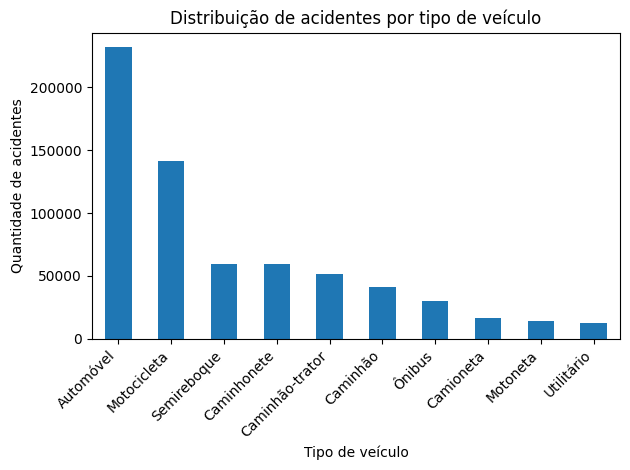

In [42]:
vehicle_type = (
    df.groupby("tipo_veiculo")
      .size()
      .sort_values(ascending=False)
).head(10)

plt.figure()
vehicle_type.plot(kind="bar")
plt.title("Distribuição de acidentes por tipo de veículo")
plt.xlabel("Tipo de veículo")
plt.ylabel("Quantidade de acidentes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
